In [1]:
from os.path import join
import json
import csv

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from IPython.display import Image
from numpy import array
from scipy.stats import t, sem, ttest_rel

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Need help? Try Stackoverflow: https://stackoverflow.com/tags/ggplot2.

  warnings.warn(x, RRuntimeWarning)


In [4]:
empo3_dir = '/Users/benkaehler/Data/empo_3/'

In [5]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')
prf = prf.join(abundances, ['sample type', 'sample'])

In [6]:
prf = prf[prf['method'] == 'weighted']

In [7]:
grouped = prf.groupby(['sample type', 'class weights', 'level'])
def weighted_stats(x):
    d1 = DescrStatsW(x['F-measure'], weights=x['abundance'])
    lower, upper = d1.tconfint_mean()
    return Series([d1.mean, lower, upper], index=['mean', 'lower', 'upper'])
figure4 = grouped.apply(weighted_stats)
figure4.reset_index(inplace=True)
old_labels = [
    'average', 'uniform70', 'bespoke70']
new_labels = [
    'Average', 'Uniform', 'Bespoke']
for old, new in zip(old_labels, new_labels):
    figure4.loc[figure4['class weights'] == old, 'class weights'] = new
figure4['class class'] = figure4['class weights']
figure4.loc[(figure4['class weights'] != 'Average') &
            (figure4['class weights'] != 'Uniform') &
            (figure4['class weights'] != 'Bespoke'),
            'class class'] = 'Cross-Habitat'

In [8]:
%%R -i figure4

figure4$class.weights = factor(figure4$class.weights, levels=c(
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline', 'Average', 'Uniform', 'Bespoke'
))

cbPalette <- c('#999999', "#56B4E9", "#E69F00", "#009E73")
figure4$class.class = factor(figure4$class.class, levels=c(
    'Cross-Habitat', 'Average', 'Uniform', 'Bespoke'))
ggplot(figure4, aes(x=level, y=mean, 
                    group=interaction(sample.type, class.weights),
                    colour=class.class)) + 
geom_line(aes(alpha=(class.class != "Cross-Habitat"))) + 
geom_smooth(aes(group=class.class), method='loess', se=FALSE) + 
theme_bw() +
  labs(y='F-measure', x='Taxonomy Level') +
  scale_alpha_manual(values=c(0.05, 0.3), guide=F) +
  scale_colour_manual(values=cbPalette) +
  guides(colour=guide_legend(title="Taxonomic Weights", reverse=T)) +
scale_x_continuous(breaks=c(1, 2, 3, 4, 5, 6, 7),
        labels=c(    'Kingdom',
    'Phylum',
    'Class',
    'Order',
    'Family',
    'Genus',
    'Species')) + 
theme(axis.text.x = element_text(angle = 30, vjust=1, hjust=1)) +
   ylim(0.7,1)

ggsave(file="figure4.png", width=5, height=5, dpi=300)

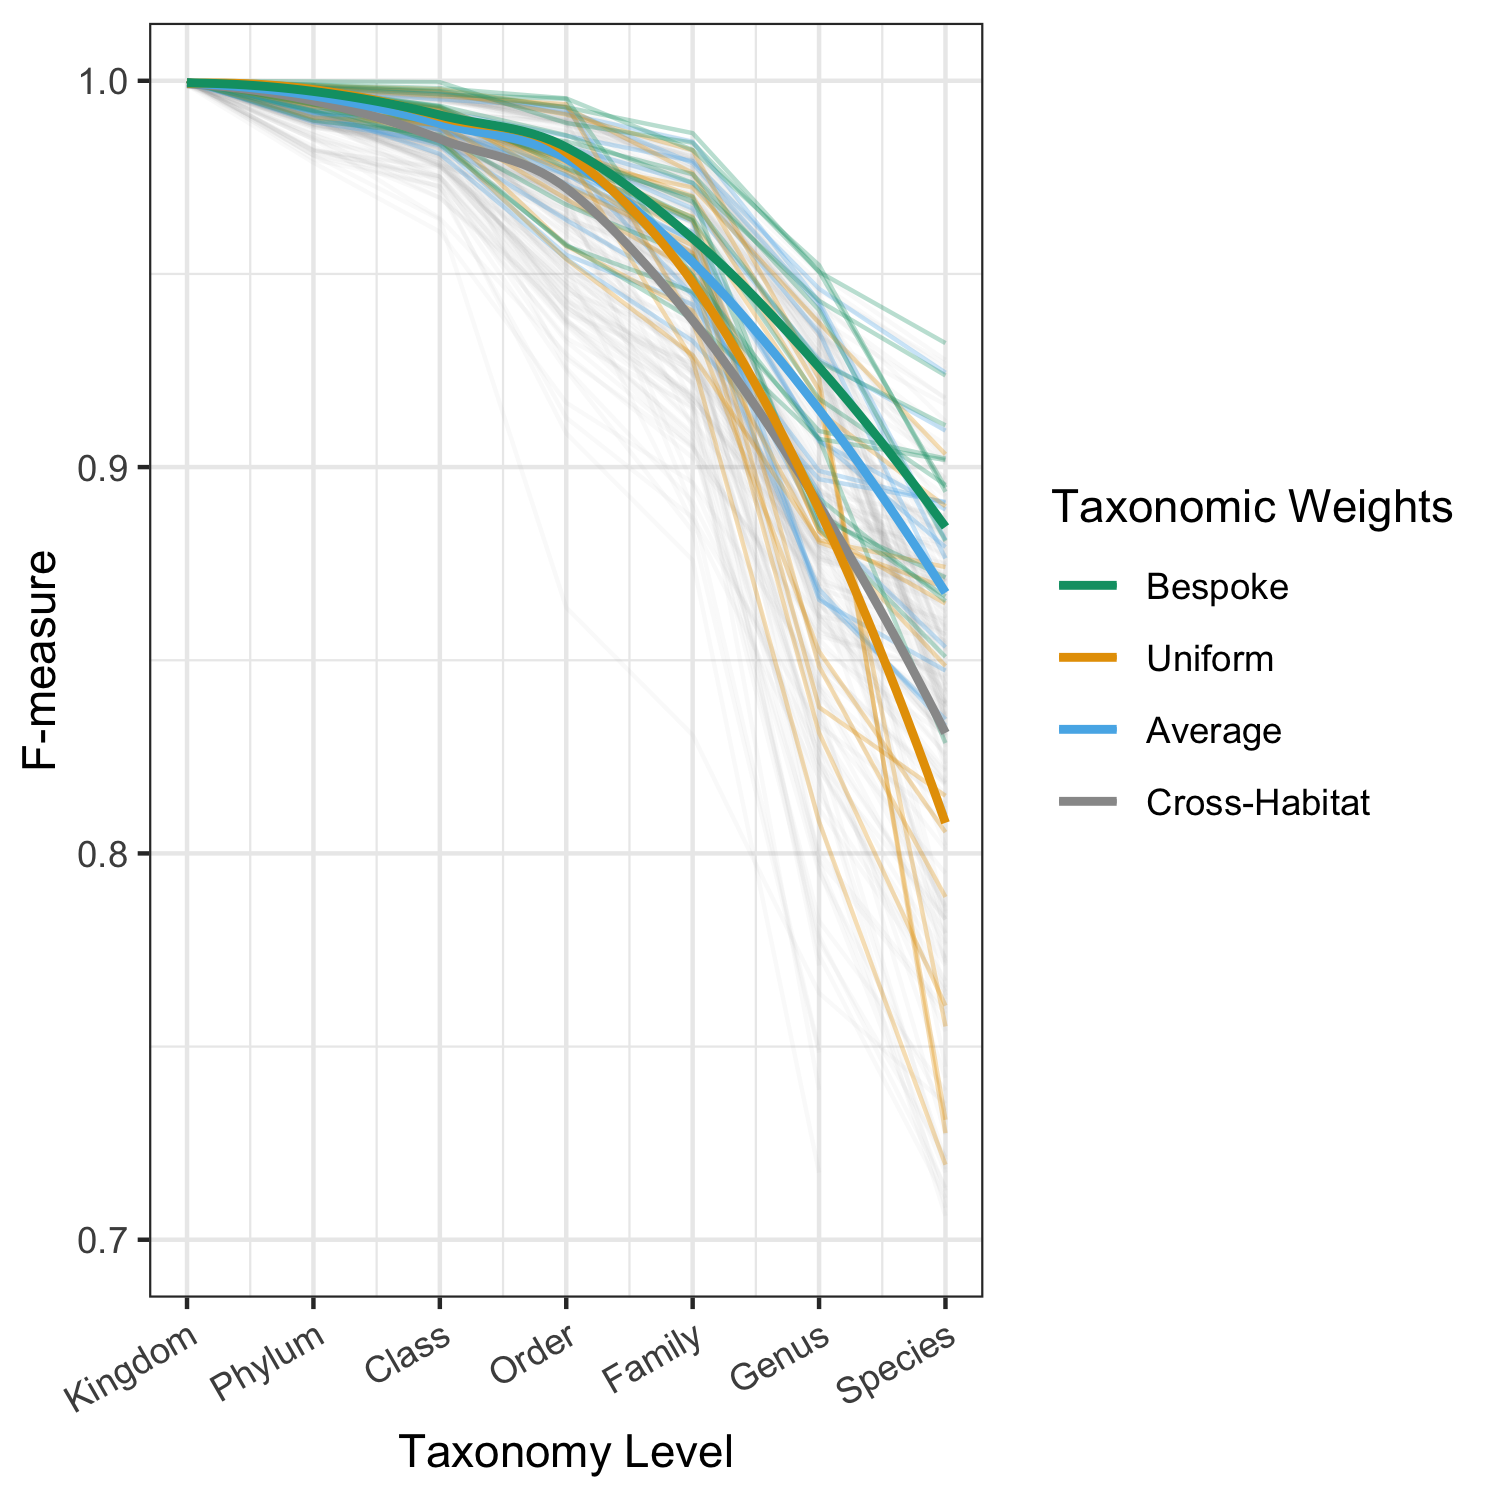

In [9]:
Image("figure4.png")

In [9]:
uniform = figure4[figure4['class class'] == 'Uniform']
print(uniform[uniform['level'] == 3]['mean'].mean())
print(sem(uniform[uniform['level'] == 3]['mean']))
print(uniform[uniform['level'] == 6]['mean'].mean())
print(sem(uniform[uniform['level'] == 6]['mean']))
print(uniform[uniform['level'] == 7]['mean'].mean())
print(sem(uniform[uniform['level'] == 7]['mean']))

0.991553154727
0.000971514001841
0.879831509346
0.0105850379277
0.810874207902
0.0172711967093


In [10]:
ttest_rel(array(uniform[uniform['level'] == 6]['mean']) - uniform[uniform['level'] == 3]['mean'],
          array(uniform[uniform['level'] == 7]['mean']) - uniform[uniform['level'] == 6]['mean'])

Ttest_relResult(statistic=-1.8744720123799761, pvalue=0.083510093048044395)

In [11]:
(array(array(uniform[uniform['level'] == 6]['mean']) - uniform[uniform['level'] == 4]['mean']) -
          (array(uniform[uniform['level'] == 7]['mean']) - uniform[uniform['level'] == 6]['mean'])).mean()

-0.028886436220853746

In [12]:
bespoke = figure4[figure4['class class'] == 'Bespoke']
ttest_rel(array(uniform[uniform['level'] == 7]['mean']),
          array(bespoke[bespoke['level'] == 7]['mean']))

Ttest_relResult(statistic=-5.8334669588962491, pvalue=5.8426367911984738e-05)

In [13]:
print(bespoke[bespoke['level'] == 3]['mean'].mean())
print(sem(bespoke[bespoke['level'] == 3]['mean']))
print(bespoke[bespoke['level'] == 6]['mean'].mean())
print(sem(bespoke[bespoke['level'] == 6]['mean']))
print(bespoke[bespoke['level'] == 7]['mean'].mean())
print(sem(bespoke[bespoke['level'] == 7]['mean']))

0.991935437912
0.00133727344883
0.918377777295
0.00683309042099
0.886993724265
0.00758096644029
